In [1]:
library(ggplot2)
library(randomForest)
library(rpart)
library(e1071)
library(DMwR)
library(ROCR)

options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: lattice

Loading required package: grid

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
df.train <- read.csv('./hw2/training.csv', sep = ',')
df.test <- read.csv('./hw2/testing.csv', sep = ',')

In [3]:
colnames(df.train)

[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EmployeeNumber"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "JobInvolvement"           "JobLevel"                
[13] "JobRole"                  "JobSatisfaction"         
[15] "MaritalStatus"            "MonthlyIncome"           
[17] "NumCompaniesWorked"       "PerformanceRating"       
[19] "RelationshipSatisfaction" "StockOptionLevel"        
[21] "TotalWorkingYears"        "TrainingTimesLastYear"   
[23] "WorkLifeBalance"          "YearsAtCompany"          
[25] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[27] "YearsWithCurrManager"

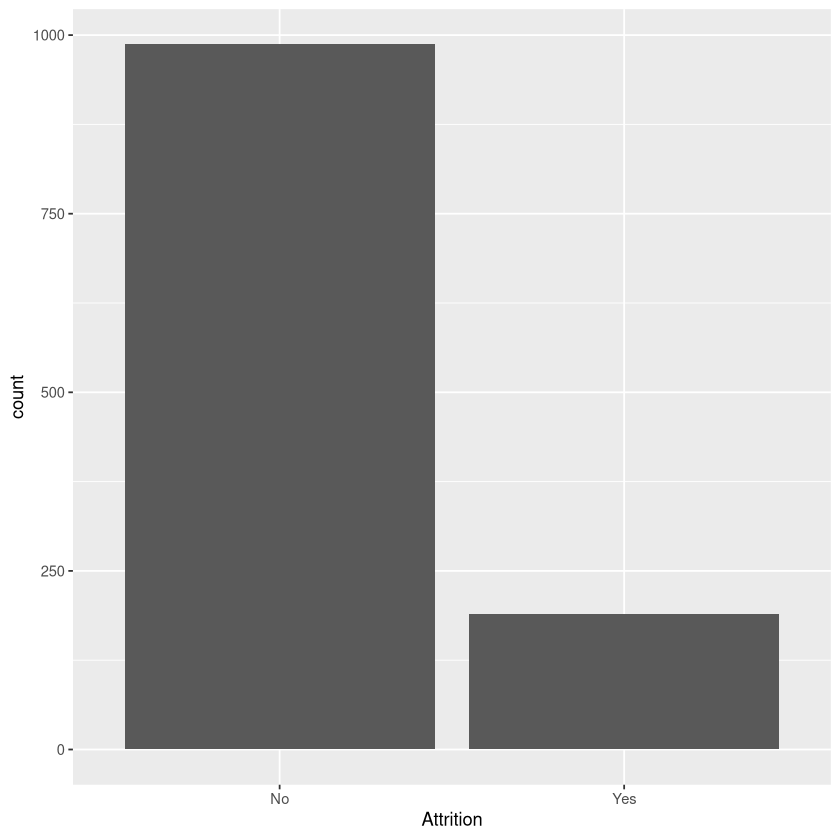

In [4]:
ggplot(df.train, aes(x = Attrition)) + geom_bar()

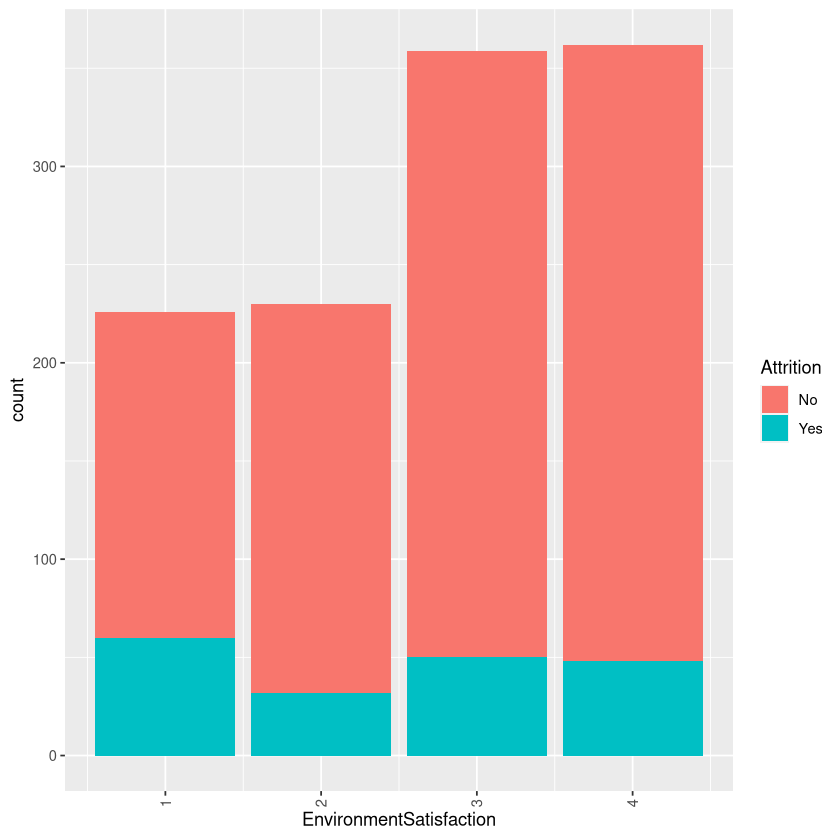

In [5]:
ggplot(df.train, aes(x = EnvironmentSatisfaction, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

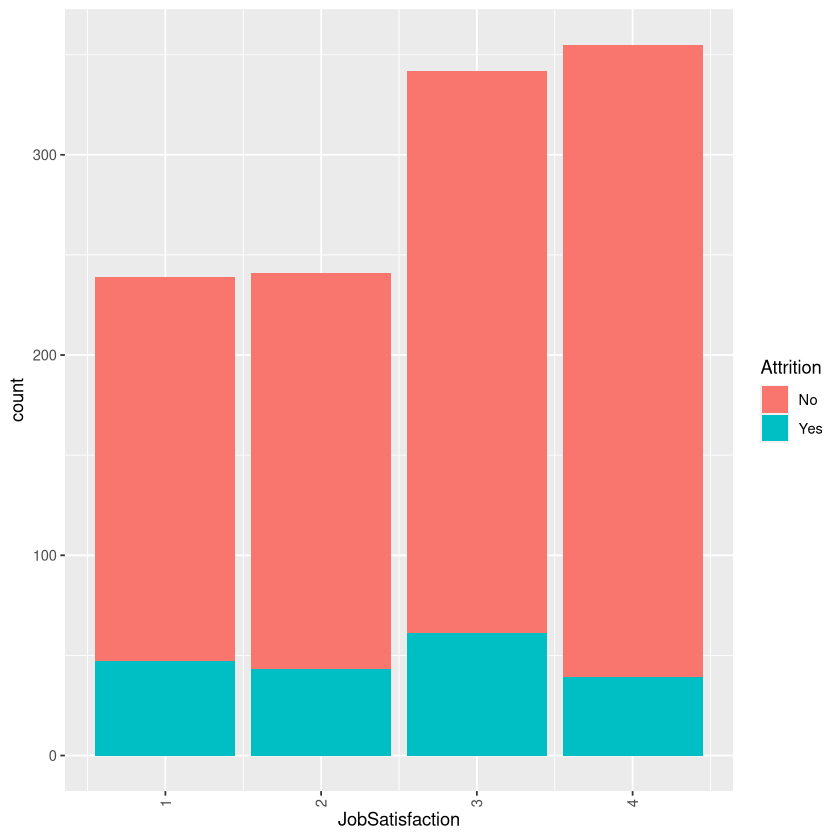

In [6]:
ggplot(df.train, aes(x = JobSatisfaction, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

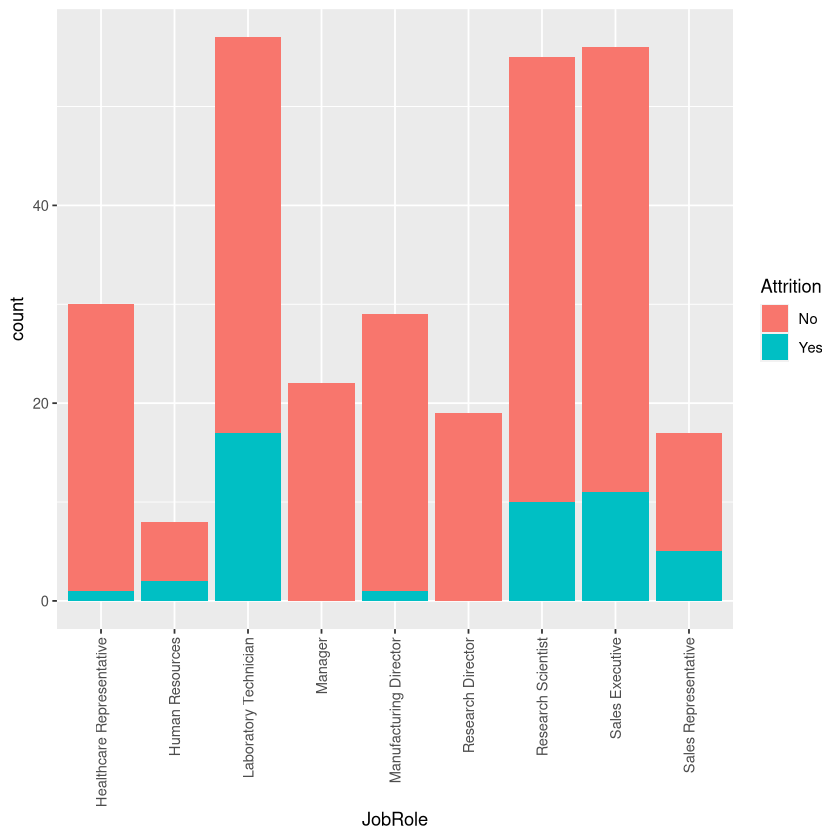

In [7]:
ggplot(df.test, aes(x = JobRole, fill = Attrition)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [8]:
set_col_to_factor <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.factor(df[, col])
  }
  return(df)
}
set_col_to_integer <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols) {
    df[, col] <- as.integer(df[, col])
  }
  return(df)
}
set_col_to_numeric <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    if(is.factor(df[, col])){
      df[, col] <- as.numeric(as.character(df[, col]))
    }else{
      df[, col] <- as.numeric(df[, col])      
    }
  } 
  return (df)
}
set_col_to_category <- function(df, old_col, new_col, mapper){
  df[new_col] <- as.factor(mapper(df[old_col]))
  return(df)
}
set_col_to_numerical_factor <- function(df, old_col, new_col) {
  df[, new_col] <- as.factor(as.numeric(as.factor(df[, old_col])))
  return(df)
}
set_col_to_log <- function(df, old_col, new_col){
  df[, new_col] <- df[, old_col]
  df[df[new_col]==0, new_col] <- 0.01
  df[, new_col] <- log10(df[, new_col])
  return(df)
}
set_col_to_scale <- function(df, old_col, new_col){
  df[, new_col] <- scale(df[, old_col])
  return(df)
}

In [9]:
build_fold_indices <- function(fold) {
  valid_fold <- 1:fold
  fold_indices <- data.frame(valid = valid_fold)
  return(fold_indices)
}
pick_out_indices <- function(total_rows, fold, ...) {
  indices <- c()
  for (i in list(...)) {
    indices <- append(indices, seq(i, total_rows, fold))
  }
  indices <- unique(indices)
  return(indices)
}
get_by_exclude <- function(df, fold, ...) {
  total_rows <- nrow(df)
  exclude <- pick_out_indices(total_rows, fold, ...)
  excluded <- df[-exclude,]
  return(excluded)
}
get_by_index <- function(df, fold, ...) {
  total_rows <- nrow(df)
  include <- pick_out_indices(total_rows, fold, ...)
  included <- df[include,]
  return(included)
}
subset_by_fold <- function(df, fold, index, indices){
  training_frame <- get_by_exclude(df,
                                   fold,
                                   indices[index, 'valid'])
  validation_frame <- get_by_index(df, fold, indices[index, 'valid'])
  return(list(training=training_frame,
              validation=validation_frame))
}
shuffle_frame <- function(df){
   set.seed(28657)
   shf_rows <- sample(nrow(df))
   shf_train <- df[shf_rows, ]
   return(shf_train)
}
remove_cols <- function(df, ...){
  cols <- unlist(list(...))
  new_df <- df[, !(names(df) %in% cols)]
  return(new_df)
}

In [10]:
gender_mapper <- function(gender){
  return(ifelse(gender == 'Male', 1, 0))
}
age_mapper <- function(age) {
  return(ifelse(age <= 30, 2,
         ifelse((31<= age && age <= 45), 3,
         ifelse(age <= 45, 1, 0))))
}
travel_mapper <- function(travel) {
  return(ifelse(travel=='Travel_Rarely', 3,
         ifelse(travel=='Travel_Frequently', 2,
         ifelse(travel=='Non-Travel', 1, 0))))
}
department_mapper <- function(department){
  return(ifelse(department=='Human Resources', 1,
         ifelse(department=='Sales', 2,
         ifelse(department=='Research & Development', 3, 0))))
}
field_mapper <- function(field) {
  # 'Medical''Other''Marketing''Human Resources''Technical Degree'
  return(ifelse(field=='Medical', 1, 
         ifelse(field=='Other', 2,
         ifelse(field=='Marketing', 3,
         ifelse(field=='Human Resources', 4,
         ifelse(field=='Technical Degree', 5, 0))))))
}
marital_mapper <- function(marital){
  return(ifelse(marital=='Single', 1,
         ifelse(marital=='Married', 2,
         ifelse(marital=='Divorced', 3, 0))))
}
attrition_mapper <- function(attrition){
  return(ifelse(attrition=='Yes', 1, 0))
}
couple_generator <- function(marital) {
  return(ifelse(marital=='Married', 1, 0))
}

In [11]:
train_dt <- function(df, depth=5) {
  model <- rpart(
    Target ~ .,
    data = df,
    control = rpart.control(maxdepth = depth),
    method = "class"
  )
  return (model)
}

predict_dt <- function(model, df) {
  pred_class <- predict(model, df, type = "class")
  pred_prob <- predict(model, df, type="prob")
  return (list(class=pred_class,
              prob=pred_prob))
}

In [12]:
train_rf <- function(df, mtry=9) {
   model <- randomForest(
     Target ~ .,
     data = df,
     mtry = mtry,
     importance=TRUE,
     proximity=TRUE,
     ntree=500)
   return (model)
 }
 predict_rf <- function(model, df) {
   pred_class <- predict(model, df, type = "class")
   pred_prob <- predict(model, df, type = "prob")
   
   return (list(class=pred_class,
               prob=pred_prob))
 }

In [13]:
train_lg <- function(df) {
  model <- glm(
    Target ~ .,
    data = df,
    family = "binomial")
  return (model)
}

predict_lg <- function(model, df, attrition_rate=0.5) {
  pred_prob <- predict(model, df, type="response")
  pred_class <- ifelse(pred_prob > attrition_rate, 1, 0)  
  return (list(class=pred_class,
              prob=pred_prob))
}

In [14]:
train_sv <- function(df, kernel='linear') {
  model_prob <- svm(
    Target ~ .,
    data = df,
    kernel = kernel,
    probability = TRUE)
  
  model_class <- svm(
    Target ~ .,
    data = df,
    kernel = kernel,
    probability = FALSE)
  return (list(class=model_class,
               prob=model_prob))
}
predict_sv <- function(model, df) {
  pred_class <- predict(model$class, df, probability = FALSE)
  pred_prob <- predict(model$prob, df, probability = TRUE)
  return (list(class=pred_class,
              prob=pred_prob))
}

In [55]:
build_cm <- function(df, pred) {
  result_frame <- data.frame(truth = df$Target,
                             pred = pred)
  result_table <- table(result_frame)
  return(result_table)
}
cal_pred_result <- function(cM) {
  true_col <- 2
  false_col <- 1
  positive_row <- 2
  negative_row <- 1
  
  TP <- cM[positive_row, ][true_col]
  FN <- cM[positive_row, ][false_col]
  TN <- cM[negative_row, ][false_col]
  FP <- cM[negative_row, ][true_col]
  
  result <- c(TP, FP, TN, FN)
  names(result) = c("TP", "FP", "TN", "FN")
  return(result)
}
get_rounded <- function(value, round_digits = 2) {
  return(round(value, digits = round_digits))
}
cal_accu <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  total_rows = TP + FN + TN + FP
  accuracy <- (TP + TN) / total_rows
  return(get_rounded(accuracy))
}
cal_sensitivity <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  sensitivity <- TP / (TP + FN)
  return(get_rounded(sensitivity))
}
cal_specificity <- function(pred_result) {
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  specificity <- TN / (TN + FP)
  return(get_rounded(specificity))
}
cal_F1 <- function(pred_result) {
  precision <- cal_precision(pred_result)
  recall <- cal_sensitivity(pred_result)
  F1 <- (2 * precision * recall) / (precision + recall)
  return(get_rounded(F1))
}
cal_precision <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FP <- unname(pred_result["FP"])
  precision <- TP / (TP + FP)
  return(get_rounded(precision))
}
evaluate_model <- function(df, pred){
  pred_class <- pred$class
  pred_prob <- pred$prob
  predict_cm <- build_cm(df, pred_class)
  predict_result <- cal_pred_result(predict_cm)
  accu <- cal_accu(predict_result)
  preci <- cal_precision(predict_result)
  sens <- cal_sensitivity(predict_result)
  recl <- sens
  spec <- cal_specificity(predict_result)
  f1 <- cal_F1(predict_result)
  #ref: https://rstudio-pubs-static.s3.amazonaws.com/309517_9364c67edcae414cab8cd9fffcc89a43.html
  # attr(pred_prob, 'probabilities')
  roc_pred <- prediction(attr(pred_prob, 'probabilities'), df$Target)
  roc_perf <- performance(roc_pred, measure = 'auc')
  r2 <- cor(as.numeric(df$Target), as.numeric(pred_class)) ^ 2
  
  return(list(cm=predict_cm,
              result=predict_result,
              accuracy=accu,
              recall=recl,
              precision=preci,
              sensitivity=sens,
              specificity=spec,
              F1=f1,
              AUC=roc_perf@y.values[[1]],
              R2=r2))
}

In [56]:
wrangling_process <- function(df){
  df <- set_col_to_category(df, 'Gender', 'Gender_1', gender_mapper)
  df <- set_col_to_category(df, 'Age', 'Age_1', age_mapper)
  df <- set_col_to_category(df, 'BusinessTravel', 'BusinessTravel_1', travel_mapper)
  df <- set_col_to_category(df, 'Department', 'Department_1', department_mapper)
  df <- set_col_to_category(df, 'EducationField', 'EducationField_1', field_mapper)
  df <- set_col_to_numerical_factor(df, 'JobRole', 'JobRole_1')
  df <- set_col_to_category(df, 'MaritalStatus', 'MaritalStatus_1', marital_mapper)
  df <- set_col_to_category(df, 'MaritalStatus', 'Couple', couple_generator)
  df <- set_col_to_numeric(df, 'Couple')
  df <- set_col_to_category(df, 'Attrition', 'Target', attrition_mapper)
  df <- set_col_to_log(df, 'MonthlyIncome', 'MonthlyIncome_1')
  df <- set_col_to_scale(df, 'TotalWorkingYears', 'TotalWorkingYears_1')
  df <- set_col_to_scale(df, 'YearsAtCompany', 'YearsAtCompany_1')
  df <- set_col_to_scale(df, 'YearsInCurrentRole', 'YearsInCurrentRole_1')
  df <- set_col_to_scale(df, 'YearsSinceLastPromotion', 'YearsSinceLastPromotion_1')
  df <- set_col_to_scale(df, 'YearsWithCurrManager', 'YearsWithCurrManager_1')
  df <- set_col_to_scale(df, 'DistanceFromHome', 'DistanceFromHome_1')
  
  df['HighSatisfy'] <- ifelse((df['EnvironmentSatisfaction']==4) & (df['JobSatisfaction']==4), 1, 0)
  df['AgvSatisfy'] <- round((df['EnvironmentSatisfaction'] + df['JobSatisfaction']) / 2, digits = 0)
  
  df <- remove_cols(df, 'Gender', 'Age', 'BusinessTravel', 'Department', 
                    'EducationField', 'JobRole', 'EmployeeNumber', 'MaritalStatus', 'Attrition',
                    'MonthlyIncome', 'EmployeeNumber',
                    'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
                    'YearsSinceLastPromotion', 'YearsWithCurrManager', 'DistanceFromHome')
  
  return(df)
}

df.procd <- shuffle_frame(wrangling_process(df.train))
head(df.procd)
summary(df.procd)

,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1,Couple,Target,MonthlyIncome_1,TotalWorkingYears_1,YearsAtCompany_1,YearsInCurrentRole_1,YearsSinceLastPromotion_1,YearsWithCurrManager_1,DistanceFromHome_1,HighSatisfy,AgvSatisfy
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
631,3,1,2,1,2,4,4,2,0,0,3,1,3,3,3,1,7,1,0,1,3.364176,-0.8076522,-0.8220256,-0.6211184,-0.05438851,-0.60477306,1.9938899,0,2
408,1,4,4,2,4,1,4,2,2,3,3,0,2,2,2,1,8,3,0,0,3.667173,-0.6770923,-0.1761483,0.1996784,-0.68198924,-0.04888248,-0.7535444,1,4
526,1,3,3,2,4,0,3,1,1,2,2,1,3,3,3,0,1,2,1,0,3.818622,0.7590666,1.4385448,1.0204752,0.57321223,1.89673455,0.6201727,0,4
587,4,1,3,2,4,0,3,2,1,2,3,0,2,3,3,0,5,2,1,0,3.626032,-0.9382121,-0.6605563,-0.6211184,-0.05438851,-0.60477306,-0.8784277,0,2
103,3,2,1,2,3,3,3,3,1,2,3,0,3,3,2,0,8,2,1,1,3.658870,-0.9382121,-0.8220256,-0.6211184,-0.05438851,-0.60477306,1.3694730,0,2
406,4,2,1,1,4,1,3,4,1,5,3,1,2,2,3,0,7,3,0,0,3.434569,-0.1548527,0.4697289,0.7468763,-0.05438851,1.06289868,-1.0033111,0,3


   Education     EnvironmentSatisfaction JobInvolvement     JobLevel    
 Min.   :1.000   Min.   :1.000           Min.   :1.000   Min.   :1.000  
 1st Qu.:2.000   1st Qu.:2.000           1st Qu.:2.000   1st Qu.:1.000  
 Median :3.000   Median :3.000           Median :3.000   Median :2.000  
 Mean   :2.926   Mean   :2.728           Mean   :2.723   Mean   :2.066  
 3rd Qu.:4.000   3rd Qu.:4.000           3rd Qu.:3.000   3rd Qu.:3.000  
 Max.   :5.000   Max.   :4.000           Max.   :4.000   Max.   :5.000  
                                                                        
 JobSatisfaction NumCompaniesWorked PerformanceRating RelationshipSatisfaction
 Min.   :1.000   Min.   :0.000      Min.   :3.000     Min.   :1.000           
 1st Qu.:2.000   1st Qu.:1.000      1st Qu.:3.000     1st Qu.:2.000           
 Median :3.000   Median :2.000      Median :3.000     Median :3.000           
 Mean   :2.691   Mean   :2.679      Mean   :3.144     Mean   :2.714           
 3rd Qu.:4.000   3rd 

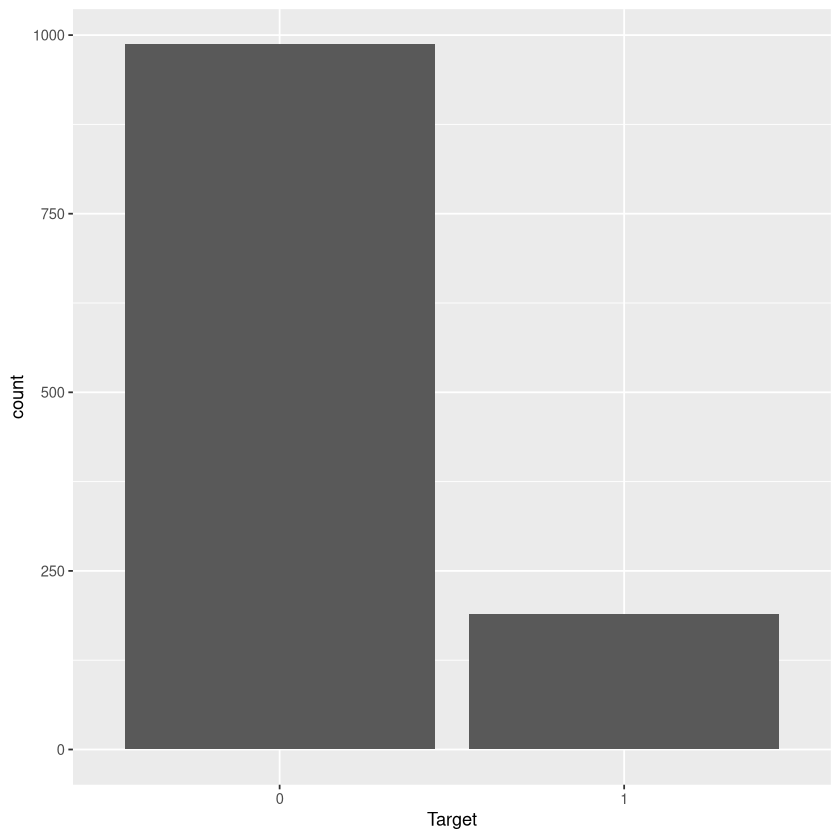

,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1,JobRole_1,MaritalStatus_1,Couple,Target,MonthlyIncome_1,TotalWorkingYears_1,YearsAtCompany_1,YearsInCurrentRole_1,YearsSinceLastPromotion_1,YearsWithCurrManager_1,DistanceFromHome_1,HighSatisfy,AgvSatisfy
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>
631,3,1,2,1,2,4,4,2,0,0,3,1,3,3,3,1,7,1,0,1,3.364176,-0.8076522,-0.8220256,-0.6211184,-0.05438851,-0.6047731,1.9938899,0,2
526,1,3,3,2,4,0,3,1,1,2,2,1,3,3,3,0,1,2,1,0,3.818622,0.7590666,1.4385448,1.0204752,0.57321223,1.8967345,0.6201727,0,4
587,4,1,3,2,4,0,3,2,1,2,3,0,2,3,3,0,5,2,1,0,3.626032,-0.9382121,-0.6605563,-0.6211184,-0.05438851,-0.6047731,-0.8784277,0,2
406,4,2,1,1,4,1,3,4,1,5,3,1,2,2,3,0,7,3,0,0,3.434569,-0.1548527,0.4697289,0.7468763,-0.05438851,1.0628987,-1.0033111,0,3
449,4,4,3,1,4,0,3,1,1,3,3,1,3,1,3,1,7,2,1,0,3.629206,-0.8076522,-0.4990870,-0.3475195,-0.36818888,-0.6047731,1.2445896,1,4
182,2,3,3,1,2,2,3,1,1,5,3,0,3,3,2,0,9,2,1,0,3.594503,-0.6770923,-0.4990870,-0.3475195,-0.36818888,-0.6047731,-0.6286610,0,2


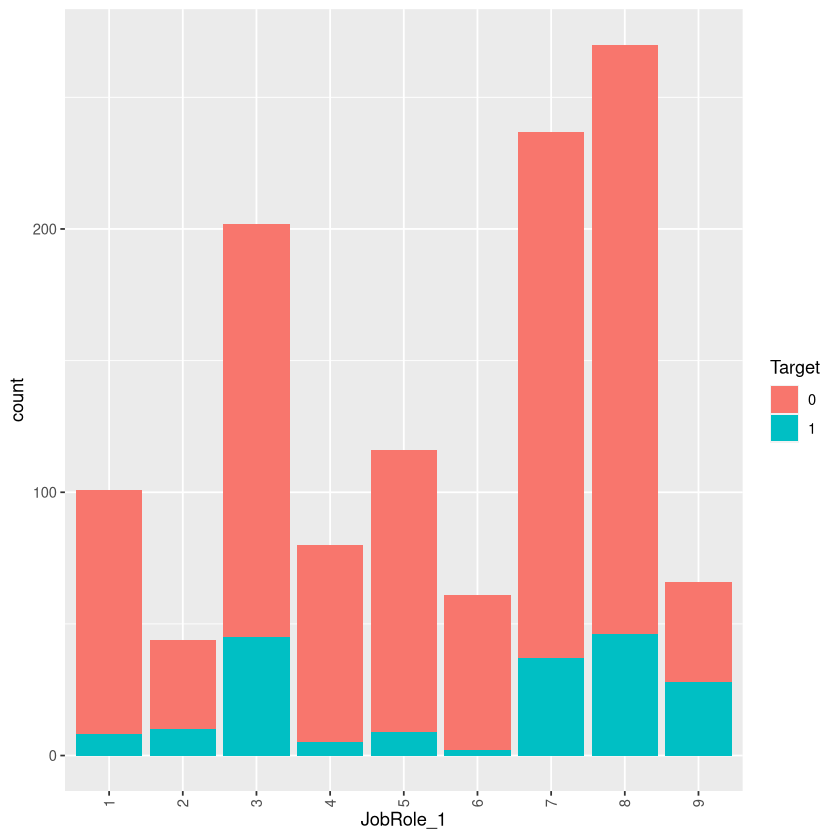

In [57]:
fold <- 3
index <- 2
# df.rsmpl <- SMOTE(Target ~ ., df.procd, perc.over = 200, perc.under=200)
df.rsmpl <- df.procd
fold_indices <- build_fold_indices(fold)
splitted_frames <- subset_by_fold(df.rsmpl, fold, index, fold_indices)
ggplot(df.rsmpl, aes(x = Target)) + geom_bar()
ggplot(df.rsmpl, aes(x = JobRole_1, fill = Target)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
head(splitted_frames$training)

In [58]:
#trainer <- (function(df) train_dt(df, 8))
#predictor <- (function(model, df) predict_dt(model, df))
# trainer <- (function(df) train_rf(df, 7))
# predictor <- (function(model, df) predict_rf(model, df))
trainer <- (function(df) train_sv(df, kernel='sigmoid'))
predictor <- (function(model, df) predict_sv(model, df))

model <- trainer(splitted_frames$training)

print('train result:')
pred_train <- predictor(model, splitted_frames$training)
result_train <- evaluate_model(splitted_frames$training, pred_train)
print(result_train)
              
print('validation:')
pred_valid <- predictor(model, splitted_frames$validation)
result_valid <- evaluate_model(splitted_frames$validation, pred_valid)
print(result_valid)

[1] "train result:"


ERROR: Error in prediction(attr(pred_prob, "probabilities"), df$Target): Number of cross-validation runs must be equal for predictions and labels.


In [26]:
print('testing:')
model.rsmpl <- trainer(df.rsmpl)
df.test2 <- wrangling_process(df.test)
pred_test <- predictor(model.rsmpl, df.test2)
result_test <- evaluate_model(df.test2, pred_test)
print(result_test)

[1] "testing:"


ERROR: Error: Format of predictions is invalid. It couldn't be coerced to a list.
